# BUAD 313 Final Project: Spotify Playlist Optimization

*by Thomaz Bonato, Senya Wong, Finny Ho, Daniel Yang*

 
> **Glossary:**
> 
> 1. Playlist Selection Model: Optimization model that selects 100 songs based on user preferences and diversity constraints
> 2. Playlist Ordering Model: Optimization model that arranges selected songs to create engagement peaks every 5 positions
> 3. Playlist Analysis: Framework for balancing selection and ordering decisions
> 4. Simulation: System for modeling user listening behavior and playlist evolution with randomness
>

#### Base Model:
> See implementation in `base_model.ipynb`

#### Inspiration: 
This project is inspired by the challenge of creating personalized playlists that balance familiar favorites with music discovery. By incorporating collaborative filtering techniques and optimization constraints, we create playlists that not only match user preferences but also introduce them to new music they're likely to enjoy. The visualization of ratings and positions helps users understand how their preferences are distributed throughout the playlist, with strategic peak positions to maintain engagement.

#### Data Wrangling & Exploration 

- **Rating Normalization**: User ratings scaled to range between -1 and 1
- **Genre Classification**: Extracted 10 most prevalent music genres from grossly messy tags (jazz, punk, classical, hip hop, pop, folk, electronic, metal, soul, alternative)
- **Artist Popularity Analysis**: Established threshold of >50M scrobbles to identify popular artists (resulting in 297 mainstream artists)
> See implementation in `eda.ipynb`

#### Parameters for User Playlist Personalization:
- $w_1, w_2$: weights for balancing rating quality and artist diversity
- $e_1$: minimum number of exploratory songs
- $e_2$: minimum number of songs from next best genre
- $a$: maximum number of popular artists allowed (since you want to be cool and like underground artists)

In [1]:
import pandas as pd
import numpy as np
import utils    # for custom made collaborative filtering functions

In [2]:
# Load data
songs = pd.read_csv('data/songs_with_normalized_ratings.csv')
artists = pd.read_csv('data/artists_with_genres.csv')

# Define subsets and mappings
exploratory_songs = songs[songs['average_prediction'] == 0]
popular_artists = artists[artists['scrobbles_lastfm'] > 50000000]
songs['genre'] = songs['artist_name'].map(dict(zip(artists['artist_mb'], artists['tags'])))
all_users = songs.columns[songs.columns.str.startswith('user_')]
songs_data = songs

# Create model sets
all_songs = list(range(len(songs)))
all_artists = list(artists['artist_mb'].unique())
exploratory_songs_indices = list(exploratory_songs.index)
popular_artists_list = list(popular_artists['artist_mb'])
position = list(range(1,101))


# Model parameters (exposed to intended user of playlist)
user = "user_5c0cba28e67a99c235ef2ba9877fef44"  # user options in all_users
w1, w2 = 0.5, 0.5       # Weights for ratings and artist diversity
e1, e2 = 10, 5          # Minimum exploratory and next-genre songs
a = 50                  # Maximum popular artists allowed

# Collaborative filtering for next best genre
user_genre_preferences = utils.calculate_genre_preferences(songs)
similar_users = utils.find_similar_users(user, user_genre_preferences, n=3)
next_best_genre = utils.find_next_best_genre(user, user_genre_preferences, similar_users, k=2)

/var/folders/vh/hr9y9xbx3tv6jypl81p3lxk80000gn/T/ipykernel_35467/3916093576.py:3: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  artists = pd.read_csv('data/artists_with_genres.csv')


In [3]:
# see all users
# all_users.tolist()

#### Info on our Collaborative Filtering to Find Next Best Genre
**Process:**
1. For each user, calculate their genre preferences
2. Find top 3 most similar users
3. Identify next best genre to explore

**Genre Preference Calculation:**
For each user, we track per-genre statistics:

| User ID | Genre 1 | Genre 2 | ... | Genre k |
|---------|---------|---------|-----|---------|
| user_1  | (total_rating, avg_rating, count) | (total_rating, avg_rating, count) | ... | (total_rating, avg_rating, count) |
| user_2  | (total_rating, avg_rating, count) | (total_rating, avg_rating, count) | ... | (total_rating, avg_rating, count) |
| ...     | ...     | ...     | ... | ...     |
| user_k  | (total_rating, avg_rating, count) | (total_rating, avg_rating, count) | ... | (total_rating, avg_rating, count) |
 
See implementation in `utils.py`

-----
## Mathematical Formulation for Song Selection Model

#### Parameters:
- $w_1, w_2$: weights for balancing rating quality and artist diversity
- $e_1$: minimum number of exploratory songs
- $e_2$: minimum number of songs from next best genre
- $a$: maximum number of popular artists allowed

#### Decision Variables:
- $S_i$: binary variable, equals 1 if song $i$ is selected for the playlist, 0 otherwise
- $A_j$: binary variable, equals 1 if artist $j$ is represented in the playlist, 0 otherwise

#### Objective Function:
Maximize: $w_1 \cdot \sum_{i \in Songs} Ratings_i \cdot S_i + \frac{w_2}{100} \cdot \sum_{j \in Artists} A_j$

This objective function balances two goals: song quality and artist diversity. The first term multiplies each song's rating by its selection variable and sums across all songs, weighted by w₁. The second term counts the total number of unique artists in the playlist, weighted by w₂/100. Higher w₁ prioritizes better-rated songs, while higher w₂ encourages including more diverse artists.

#### Constraints:

$\sum_{i \in Songs} S_i = 100$                                                
*Pick 100 songs*

$\sum_{i \in ExploratorySongs} S_i \geq e_1$                                     
*Explore songs from exploratory set*

$\sum_{i \in Songs, Genre_i = NextBestGenre} S_i \geq e_2$                       
*Explore songs from the next best genre*

$A_j \leq \sum_{i \in Songs, Artist_i = j} S_i \quad \forall j \in Artists$      
*Map Artists to Songs*

$\sum_{j \in PopularArtists} A_j \leq a$                                         
*Limit total number of popular artists*

$e_1 + e_2 \leq 100$                                                             
*Constraint on exploratory parameters*

In [4]:
def select_songs(user, w1, w2, e1, e2, a, songs_data, all_songs, all_artists, exploratory_songs_indices, popular_artists_list, next_best_genre):
    from gurobipy import Model, GRB, quicksum
    print("Creating Song Selection Model...")

    # Create a new model
    model = Model("Song_Selection_Model")

    # Create decision variables
    S = model.addVars(all_songs, vtype=GRB.BINARY, name="S")
    A = model.addVars(all_artists, vtype=GRB.BINARY, name="A_")

    # Objective function: maximize weighted sum of ratings and artist diversity
    model.setObjective(
        w1 * quicksum(songs_data.iloc[i][user] * S[i] for i in all_songs) +
        w2 / 100 * quicksum(A[j] for j in all_artists),
        GRB.MAXIMIZE
    )

    # Constraint 1: Pick 100 songs
    model.addConstr(quicksum(S[i] for i in all_songs) == 100, "max_songs")

    # Constraint 2: Minimum number of exploratory songs
    model.addConstr(quicksum(S[i] for i in exploratory_songs_indices) >= e1, "min_exploratory")

    # Constraint 3: Minimum number of songs from next best genre
    # Pre-compute indices to avoid repeated iloc lookups
    next_best_genre_indices = []
    for i in all_songs:
        if isinstance(songs_data.iloc[i]['genre'], str) and next_best_genre in songs_data.iloc[i]['genre']:
            next_best_genre_indices.append(i)
    model.addConstr(quicksum(S[i] for i in next_best_genre_indices) >= e2, "min_next_best_genre")

    # Constraint 4: Map Artists to Songs
    # Create a dictionary to map artists to their songs to avoid repeated lookups
    artist_to_songs = {}
    for j in all_artists:
        artist_to_songs[j] = []

    # Populate the dictionary
    for i in all_songs:
        artist_name = songs_data.iloc[i]['artist_name']
        # Fix: Check if artist_name exists in artist_to_songs dictionary
        if artist_name in all_artists:
            artist_to_songs[artist_name].append(i)

    # Add constraints using the pre-computed mapping
    print("Adding artist mapping constraints (this may take a while)...")
    count = 0
    for j in all_artists:
        # Only add constraint if the artist has songs in our dataset
        if artist_to_songs[j]:  # Check if the list is not empty
            model.addConstr(A[j] <= quicksum(S[i] for i in artist_to_songs[j]), f"artist_map_{j}")
            count += 1

    # Constraint 5: Limit total number of popular artists
    popular_artist_vars = [A[j] for j in all_artists if j in popular_artists_list]
    model.addConstr(quicksum(popular_artist_vars) <= a, "max_popular_artists")

    # Constraint 6: Constraint on exploratory parameters
    # This is already enforced by our parameter choices, but we add it for completeness
    model.addConstr(e1 + e2 <= 100, "exploratory_limit")
    print("All constraints added, ready to optimize")

    # Optimize the model
    print("Optimizing the model...")
    model.optimize()

    # Print results if optimal solution found
    if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
        if model.status == GRB.TIME_LIMIT:
            print("Time limit reached. Using best solution found.")
        else:
            print(f"Optimal objective value: {model.objVal:.4f}")
        
        # Get selected songs
        selected_songs = [i for i in all_songs if S[i].X > 0.5]
        selected_songs_df = songs_data.iloc[selected_songs]

        return selected_songs_df, model.objVal
    else:
        print(f"No optimal solution found. Status code: {model.status}")
        
        # Print infeasibility diagnostics
        if model.status == GRB.INFEASIBLE:
            print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
            model.computeIIS()
            print("The following constraints cannot be satisfied simultaneously:")
            for c in model.getConstrs():
                if c.IISConstr:
                    print(f"  {c.ConstrName}")
        
        return None, None
    
selected_songs_df, obj_val = select_songs(user, w1, w2, e1, e2, a, songs_data, all_songs, all_artists, exploratory_songs_indices, popular_artists_list, next_best_genre)
selected_songs_df[["track_name", "artist_name"]]


Creating Song Selection Model...
Set parameter Username
Set parameter LicenseID to value 2609932
Academic license - for non-commercial use only - expires 2026-01-14
Adding artist mapping constraints (this may take a while)...
All constraints added, ready to optimize
Optimizing the model...
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7485 rows, 1372995 columns and 57076 nonzeros
Model fingerprint: 0x0bf6afa7
Variable types: 0 continuous, 1372995 integer (1372995 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+02]
Found heuristic solution: objective 6742.1261435
Presolve removed 1 rows and 1345465 columns
Presolve time: 0.07s
Presolved: 7484 rows, 27530 columns, 57007 nonzeros
Found heuristic solution: object

,track_name,artist_name
131,Arrival (feat. Brute Force) (Ashley Wallbridge...,Gareth Emery
382,A Rush of Blood to the Head,Coldplay
464,Flying Teapot,The Seatbelts
497,Nocturne,Daft Punk
506,The Scientist (Turico Dubstep Remix),Coldplay
...,...,...
19504,42 [Live],Coldplay
19521,trouble,Coldplay
19548,Strawberry Swing(Live),Coldplay
19708,Viva La Vida (Live),Coldplay


-----
## Mathematical Formulation for Song Ordering Model

goal: we get a list of all 100 songs picked from the improved model
we then want to order them to artificially create "peaks" within a playlist
we want to maximize the rating every 5 songs in order to create a more engaging playlist

WHY? 
This formulation will create a playlist where higher-rated songs tend to appear at peak positions (multiples of 5), 
creating an engaging listening experience with regular high points.

#### Parameters:
- $SelectedSongs$: set of songs selected from the previous model
- $Positions$: set of positions in the playlist (1 to 100)
- $Ratings_i$: rating of song $i$
- $Peaks$: set of peak positions (5, 10, 15, ..., 100)

#### Decision Variables:
- $X_{i,j}$: binary variable, equals 1 if song $i$ is placed at position $j$ in the playlist, 0 otherwise

#### Objective Function:
Maximize: $\sum_{i \in SelectedSongs} \sum_{j \in Peaks} Ratings_i \cdot X_{i,j}$       
This objective function maximizes the sum of song ratings at peak positions.
By placing higher-rated songs at peak positions (every 5th position),
we create a playlist with regular high points that maintains user engagement.

#### Constraints:

$\sum_{i \in SelectedSongs} X_{i,j} = 1 \quad \forall j \in Positions$      
*Each position must have exactly one song*

$\sum_{j \in Positions} X_{i,j} = 1 \quad \forall i \in SelectedSongs$      
*Each selected song must be used exactly once*

$\sum_{i \in SelectedSongs} \sum_{j \in Positions} X_{i,j} = 100$       
*Total number of songs must be 100*


In [5]:
def generate_playlist(selected_songs_df, user):
    # Implementation of the Song Ordering Model using Gurobi
    from gurobipy import Model, GRB, quicksum

    # Create a new model
    print("Creating Song Ordering Model...")
    ordering_model = Model("Song_Ordering_Model")

    # Extract data from the selected songs
    selected_songs = list(range(len(selected_songs_df)))
    positions = list(range(1, 101))
    peaks = [1] + [5*i for i in range(1, 21)]  # 1, 5, 10, 15, ..., 100

    # Get ratings for selected songs
    ratings = selected_songs_df[user].values

    print(f"Number of selected songs: {len(selected_songs)}")
    print(f"Peak positions: {peaks}")

    # Create decision variables
    print("Creating decision variables...")
    X = {}
    for i in selected_songs:
        for j in positions:
            X[i, j] = ordering_model.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}")

    # Set objective function: maximize the sum of ratings at peak positions
    print("Setting objective function...")
    objective = quicksum(ratings[i] * X[i, j] for i in selected_songs for j in peaks)
    ordering_model.setObjective(objective, GRB.MAXIMIZE)

    # Add constraints
    print("Adding constraints...")

    # Constraint 1: Each position must have exactly one song
    for j in positions:
        ordering_model.addConstr(quicksum(X[i, j] for i in selected_songs) == 1, f"one_song_per_position_{j}")

    # Constraint 2: Each selected song must be used exactly once
    for i in selected_songs:
        ordering_model.addConstr(quicksum(X[i, j] for j in positions) == 1, f"use_song_once_{i}")

    # Constraint 3: Total number of songs must be 100 (redundant given constraints 1 and 2, but added for completeness)
    ordering_model.addConstr(quicksum(X[i, j] for i in selected_songs for j in positions) == 100, "total_songs")

    # Optimize the model
    print("Optimizing the Song Ordering Model...")
    ordering_model.optimize()

    # Process results
    if ordering_model.status == GRB.OPTIMAL:
        print(f"Optimal objective value: {ordering_model.objVal:.4f}")
        
        # Create a dictionary to store the position of each song
        song_positions = {}
        for i in selected_songs:
            for j in positions:
                if X[i, j].X > 0.5:  # If the variable is set to 1
                    song_positions[j] = i
        
        # Create the ordered playlist
        ordered_playlist = pd.DataFrame({
            'position': [],
            'track_name': [],
            'artist_name': [],
            'rating': [],
            'genre': []
        })
        
        for pos in sorted(song_positions.keys()):
            song_idx = song_positions[pos]
            ordered_playlist = pd.concat([ordered_playlist, pd.DataFrame({
                'position': [pos],
                'track_name': [selected_songs_df.iloc[song_idx]['track_name']],
                'artist_name': [selected_songs_df.iloc[song_idx]['artist_name']],
                'rating': [selected_songs_df.iloc[song_idx][user]],
                'genre': selected_songs_df.iloc[song_idx]['genre']
            })], ignore_index=True)
        
        # Highlight the peak positions
        peak_songs = ordered_playlist[ordered_playlist['position'].isin(peaks)]
        
        # Calculate average rating at peak positions vs. non-peak positions
        avg_rating_peaks = peak_songs['rating'].mean()
        non_peak_songs = ordered_playlist[~ordered_playlist['position'].isin(peaks)]
        avg_rating_non_peaks = non_peak_songs['rating'].mean()
        
        print(f"Rating at peak positions: {avg_rating_peaks:.4f}")
        print(f"Rating at non-peak positions: {avg_rating_non_peaks:.4f}")
        return ordered_playlist
        
    else:
        print(f"No optimal solution found. Status code: {ordering_model.status}")
        return None

In [6]:
ordered_playlist = generate_playlist(selected_songs_df, user)
ordered_playlist[["track_name", "artist_name"]]

Creating Song Ordering Model...
Number of selected songs: 100
Peak positions: [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
Creating decision variables...
Setting objective function...
Adding constraints...
Optimizing the Song Ordering Model...
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 201 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0xb78f7fc8
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.02s
Presolved: 200 rows, 10000 columns, 20000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective 9.457814

,track_name,artist_name
0,yellow,Coldplay
1,Io scriverò,Rino Gaetano
2,Lovers In Japan - Acoustic Version,Coldplay
3,X and Y,Coldplay
4,Swallowed In The Sea,Coldplay
...,...,...
95,Nocturne,Daft Punk
96,Every Teardrop is a Waterfall,Coldplay
97,Manoir Des Mes Reves - aka Django&apos;s Castle,Django Reinhardt
98,make love,Daft Punk


-----
## Playlist Analysis: Balancing Selection and Ordering

Our playlist generation involves a two-stage optimization approach that balances multiple objectives:

### Selection Model Trade-offs
The first visualization set examines how well our selection model balances:
- **User Preferences**: Including songs with high predicted ratings
- **Artist Diversity**: Introducing variety through the artist diversity constraint
- **Genre Exploration**: Incorporating songs from the collaborative filtering-recommended "next best genre"
- **Discovery**: Including exploratory songs (rating = 0) to expand user horizons

### Ordering Model Effectiveness
The second visualization set evaluates our strategic song placement approach:
- **Peak Position Impact**: Analyzing whether high-rated songs placed at strategic peak positions (1, 5, 10, etc.) maintain user engagement
- **Flow Management**: Examining the distribution of known vs. exploratory content throughout the playlist
- **Engagement Patterns**: Visualizing how ratings fluctuate across the playlist to create an engaging listening experience

These analyses help us understand how our dual optimization approach creates playlists that balance familiarity with discovery while maintaining user engagement through strategic song ordering.

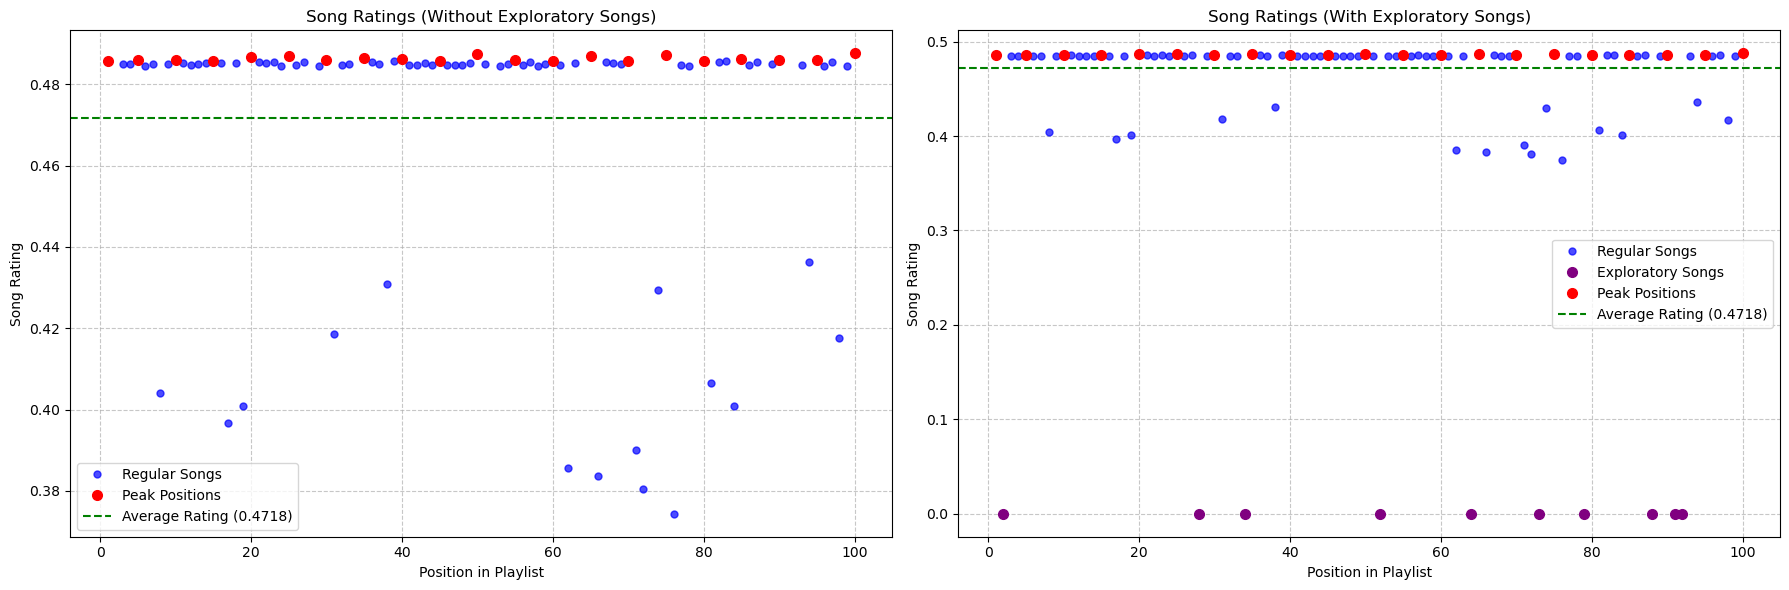

Total number of unique genres: 10
Most common genre: pop (86 occurrences)
Total number of unique artists: 28
Most common artist: Coldplay (71 songs)


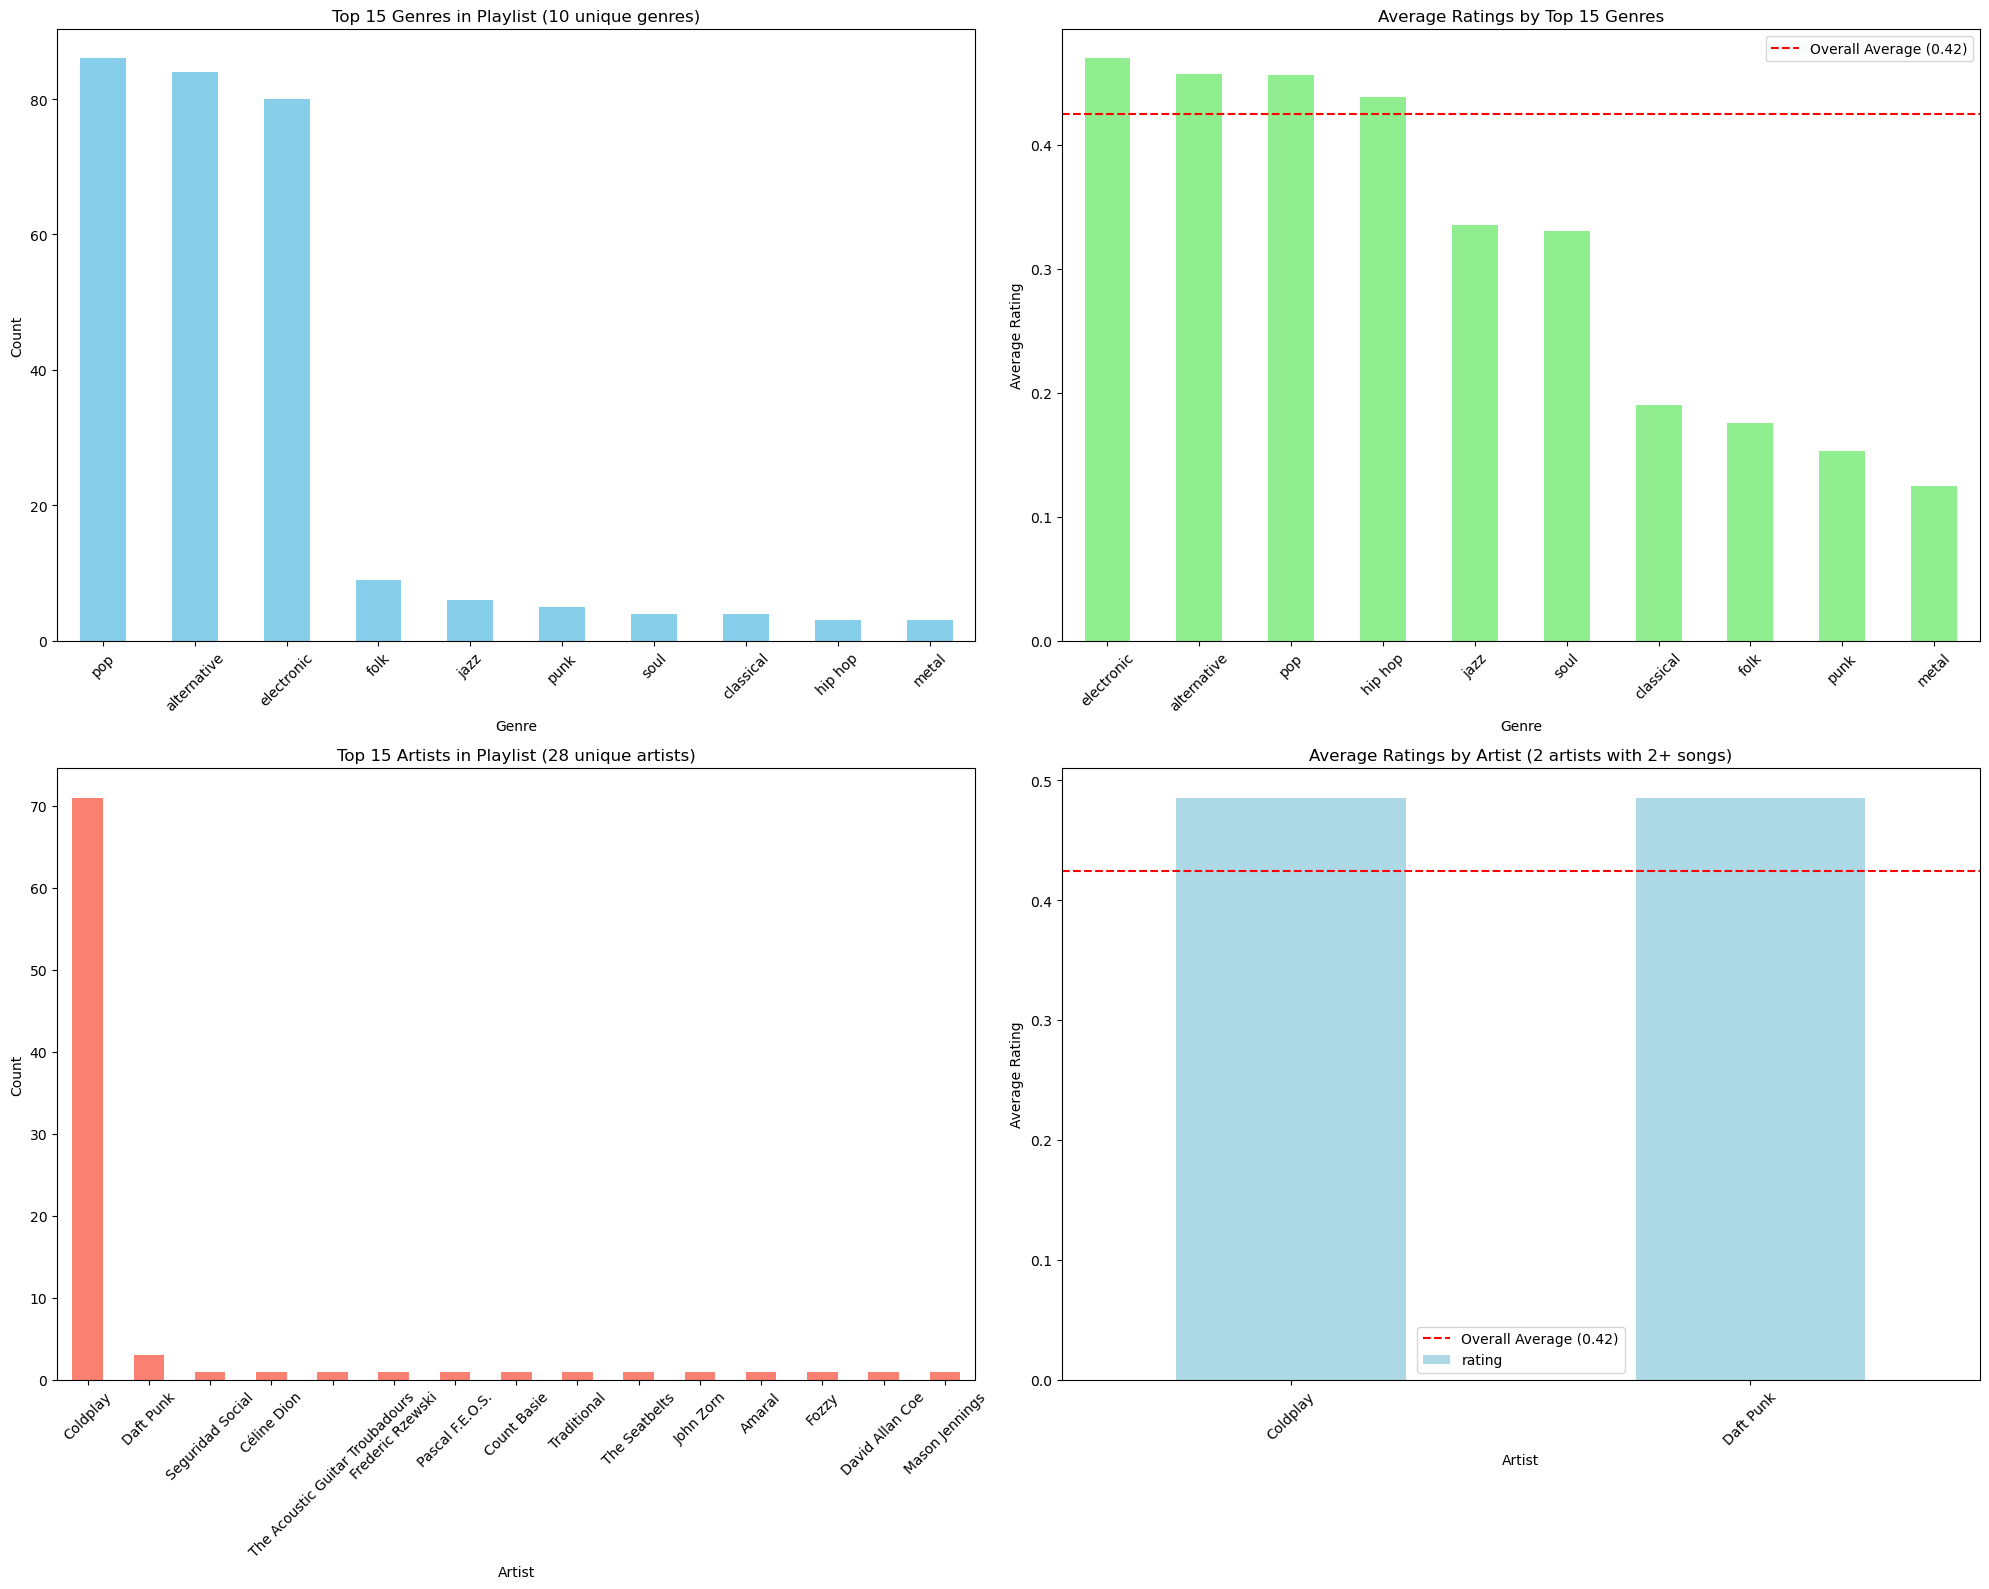

In [7]:
# plot the ratings and positions of the final playlist
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

peaks = [1] + [5*i for i in range(1, 21)]
peak_songs = ordered_playlist[ordered_playlist['position'].isin(peaks)]
exploratory_songs = ordered_playlist[ordered_playlist['rating'] == 0]
regular_songs = ordered_playlist[ordered_playlist['rating'] > 0]

ax1.plot(regular_songs['position'], regular_songs['rating'], 'o', color='blue', alpha=0.7, markersize=5, label='Regular Songs')

peak_regular_songs = peak_songs[peak_songs['rating'] > 0]
ax1.plot(peak_regular_songs['position'], peak_regular_songs['rating'], 'o', color='red', markersize=7, label='Peak Positions')

ax1.set_xlabel('Position in Playlist')
ax1.set_ylabel('Song Rating')
ax1.set_title('Song Ratings (Without Exploratory Songs)')
ax1.grid(True, linestyle='--', alpha=0.7)
avg_rating = regular_songs['rating'].mean() if not regular_songs.empty else 0
ax1.axhline(y=avg_rating, color='green', linestyle='--', 
            label=f'Average Rating ({avg_rating:.4f})')
ax1.legend()

# Second subplot - with exploratory songs
# Plot the regular songs
ax2.plot(regular_songs['position'], regular_songs['rating'], 'o', color='blue', alpha=0.7, markersize=5, label='Regular Songs')

# Plot exploratory songs
if not exploratory_songs.empty:
    ax2.plot(exploratory_songs['position'], exploratory_songs['rating'], 'o', color='purple', markersize=7, label='Exploratory Songs')

# Highlight peak positions
ax2.plot(peak_songs['position'], peak_songs['rating'], 'o', color='red', markersize=7, label='Peak Positions')

ax2.set_xlabel('Position in Playlist')
ax2.set_ylabel('Song Rating')
ax2.set_title('Song Ratings (With Exploratory Songs)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(y=avg_rating, color='green', linestyle='--', 
            label=f'Average Rating ({avg_rating:.4f})')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Analyze the distribution of genres and artists in the playlist
# Convert genre strings to lists if they're in string format
ordered_playlist['genre'] = ordered_playlist['genre'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Count occurrences of each genre
all_genres = []
for genre_list in ordered_playlist['genre']:
    # Skip if not iterable (like float NaN values)
    if isinstance(genre_list, (list, tuple)):
        all_genres.extend(genre_list)

# Create a counter for genres
from collections import Counter
genre_counts = Counter(all_genres)

# Create a figure with 2x2 subplots for all visualizations
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Check if we have genre information in our dataset
if 'genre' in ordered_playlist.columns:
    # Create a list of all genres (handling potential NaN values)
    all_genres = []
    for genre_list in ordered_playlist['genre']:
        # Skip if not iterable (like float NaN values)
        if isinstance(genre_list, (list, tuple)):
            all_genres.extend(genre_list)
    
    # Create a DataFrame for genre analysis
    genre_df = pd.DataFrame({'genre': all_genres})
    
    # Plot 1: Genre distribution (top left)
    genre_counts = pd.Series(genre_df['genre'].value_counts().head(15))  # Show top 15 genres
    genre_counts.plot(kind='bar', color='skyblue', ax=axs[0, 0])
    axs[0, 0].set_title(f'Top 15 Genres in Playlist ({len(set(all_genres))} unique genres)')
    axs[0, 0].set_xlabel('Genre')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].tick_params(axis='x', rotation=45, labelrotation=45)
    
    # Plot 2: Ratings by genre (top right)
    # Calculate average rating for each genre
    genre_ratings = {}
    for idx, row in ordered_playlist.iterrows():
        if isinstance(row['genre'], (list, tuple)):
            for genre in row['genre']:
                if genre not in genre_ratings:
                    genre_ratings[genre] = []
                genre_ratings[genre].append(row['rating'])
    
    avg_genre_ratings = {genre: sum(ratings)/len(ratings) 
                         for genre, ratings in genre_ratings.items() 
                         if len(ratings) > 0}
    
    genre_ratings_series = pd.Series(avg_genre_ratings).sort_values(ascending=False).head(15)
    genre_ratings_series.plot(kind='bar', color='lightgreen', ax=axs[0, 1])
    axs[0, 1].set_title(f'Average Ratings by Top 15 Genres')
    axs[0, 1].set_xlabel('Genre')
    axs[0, 1].set_ylabel('Average Rating')
    axs[0, 1].tick_params(axis='x', rotation=45, labelrotation=45)
    axs[0, 1].axhline(y=ordered_playlist['rating'].mean(), color='red', linestyle='--', 
                label=f'Overall Average ({ordered_playlist["rating"].mean():.2f})')
    axs[0, 1].legend()

# Plot 3: Artist distribution (bottom left)
artist_counts = ordered_playlist['artist_name'].value_counts().head(15)  # Show top 15 artists
artist_counts.plot(kind='bar', color='salmon', ax=axs[1, 0])
axs[1, 0].set_title(f'Top 15 Artists in Playlist ({ordered_playlist["artist_name"].nunique()} unique artists)')
axs[1, 0].set_xlabel('Artist')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45, labelrotation=45)

# Plot 4: Ratings by artist (bottom right)
artist_song_counts = ordered_playlist['artist_name'].value_counts()
artists_with_multiple_songs = artist_song_counts[artist_song_counts >= 2].index
if len(artists_with_multiple_songs) > 0:
    artist_ratings = ordered_playlist[ordered_playlist['artist_name'].isin(artists_with_multiple_songs)]\
                    .groupby('artist_name')['rating'].mean().sort_values(ascending=False)
    artist_ratings.plot(kind='bar', color='lightblue', ax=axs[1, 1])
    axs[1, 1].set_title(f'Average Ratings by Artist ({len(artists_with_multiple_songs)} artists with 2+ songs)')
    axs[1, 1].set_xlabel('Artist')
    axs[1, 1].set_ylabel('Average Rating')
    axs[1, 1].tick_params(axis='x', rotation=45, labelrotation=45)
    axs[1, 1].axhline(y=ordered_playlist['rating'].mean(), color='red', linestyle='--', 
                label=f'Overall Average ({ordered_playlist["rating"].mean():.2f})')
    axs[1, 1].legend()

# Print some statistics about genres and artists
if 'genre' in ordered_playlist.columns:
    # Count unique genres across all songs
    all_unique_genres = set()
    for genre_list in ordered_playlist['genre']:
        # Skip if not iterable (like float NaN values)
        if isinstance(genre_list, (list, tuple)):
            all_unique_genres.update(genre_list)
    
    # Find most common genre
    from collections import Counter
    genre_counts = Counter(all_genres)
    most_common_genre = genre_counts.most_common(1)[0][0]
    most_common_genre_count = genre_counts.most_common(1)[0][1]
    
    print(f"Total number of unique genres: {len(all_unique_genres)}")
    print(f"Most common genre: {most_common_genre} ({most_common_genre_count} occurrences)")
else:
    print("Genre information not available")

print(f"Total number of unique artists: {ordered_playlist['artist_name'].nunique()}")
print(f"Most common artist: {ordered_playlist['artist_name'].value_counts().index[0]} "
      f"({ordered_playlist['artist_name'].value_counts().iloc[0]} songs)")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


----
## Simulation: Modeling User Listening and Playlist Evolution

This simulation models a user's music listening behavior over 100 days, tracking how song ratings change and how playlist regeneration affects the overall experience.

#### Daily Listening and Rating Dynamics:
- **Initial State:** Begins with a 100-song playlist
- **Daily Interaction:** User "listens" to every song daily
- **Rating System:**
  - Ratings range from -1 (dislike) to 1 (like)
  - New songs receive random initial ratings between -1 and 1
  - Existing songs' ratings shift slightly each listen
- **Global Rating Memory:** All ratings persist in a global dictionary

#### Playlist Regeneration and Exploration:
- **Periodic Reselection:** Playlist regenerates every 10 days
- **Regeneration Mechanism:** Uses `select_songs` function with exploration parameters
- **Rating Handling:** Previously rated songs keep their ratings; new songs start at 0.0

#### Goal of our playlist:
- Balance user satisfaction with music discovery
- Maintain a high average rating while introducing new content
- Adapt to changing user preferences over time
- Provide a mix of familiar favorites and novel recommendations
- Evaluate the effectiveness of different exploration parameters

In [8]:
# Assume 'selected_songs_df' DataFrame is already loaded from a previous cell.
# It should contain 'track_name' and 'artist_name' columns for the initial 100-song playlist.

# Initialize a global dictionary to store ratings for all unique songs encountered.
# This ensures that ratings persist across playlist regenerations.
global_song_ratings = {}

# Prepare the initial selected_songs DataFrame:
# 1. Ensure it has a 'rating' column.
# 2. If 'rating' column exists but has NaNs, fill them with 0.0.
# 3. If 'rating' column doesn't exist, add it and initialize all ratings to 0.0.
# 4. Populate global_song_ratings with these initial ratings.

# Using .loc for assignments to potentially avoid SettingWithCopyWarning
if user not in selected_songs_df.columns:
    selected_songs_df.loc[:, user] = 0.0  # Initialize with 0.0 for all songs
else:
    selected_songs_df.loc[:, user] = selected_songs_df[user].fillna(0.0) # Fill NaNs if any

# Ensure rating column is float
selected_songs_df.loc[:, user] = selected_songs_df[user].astype(float)

for _, row in selected_songs_df.iterrows():
    song_key = (row['track_name'], row['artist_name'])
    global_song_ratings[song_key] = row[user]

simulation_days = 50
simulation_history = [] # To store data like daily average rating

# Main simulation loop
for day in range(1, simulation_days + 1):
    
    # Daily listening: Iterate through each song in the current playlist
    # Create a list to store ratings for the current day to calculate daily average
    current_day_playlist_ratings = []

    for index, song_row in selected_songs_df.iterrows():
        song_key = (song_row['track_name'], song_row['artist_name'])
        
        # Current rating is sourced from our persistent global_song_ratings
        current_rating = global_song_ratings.get(song_key, 0.0)

        # Case 2: Song has never been rated (or rating is 0)
        if current_rating == 0.0:
            new_rating = np.random.uniform(-1, 1)
        # Case 1: Song already had a rating
        else:
            # Randomly choose whether to attempt to move the rating closer to 1 or -1
            target_extreme = np.random.choice([-1, 1])
            
            # Define the magnitude of change (a small random step)
            change_step = np.random.uniform(0.05, 0.15) 
            
            if target_extreme == 1:  # Try to move rating towards 1
                new_rating = current_rating + change_step
            else:  # Try to move rating towards -1
                new_rating = current_rating - change_step
            
            # Ensure the new rating stays within the [-1, 1] bounds
            new_rating = np.clip(new_rating, -1, 1)
            
        # Update the rating in the current playlist's DataFrame
        selected_songs_df.loc[index, user] = new_rating
        # Update the rating in our persistent global song ratings store
        global_song_ratings[song_key] = new_rating
        
        current_day_playlist_ratings.append(new_rating)

    # Calculate and store daily statistics (e.g., average rating of the current playlist)
    if current_day_playlist_ratings: # Check if playlist is not empty
        daily_avg_rating = np.mean(current_day_playlist_ratings)
        num_songs_in_playlist = len(current_day_playlist_ratings)
        simulation_history.append({
            'day': day, 
            'avg_rating': daily_avg_rating, 
            'num_songs_in_playlist': num_songs_in_playlist
        })
        
        # Print summary at start of each 10-day cycle
        if day % 10 == 1:
            cycle_start = day
            cycle_end = min(day + 9, simulation_days)
            print(f"Day {cycle_start}-{cycle_end}: Listened to {num_songs_in_playlist} songs. Average rating: ", end="")
        # Stream rating for the day
        print(f"{daily_avg_rating:.4f}", end="", flush=True)
        # Add comma if not last day of cycle
        if day % 10 != 0 and day != simulation_days:
            print(", ", end="", flush=True)
        else:
            print() # New line at end of cycle
            
    else:
        simulation_history.append({'day': day, 'avg_rating': np.nan, 'num_songs_in_playlist': 0})
        print(f"Day {day}: Playlist was empty. No songs listened to.")

    # Playlist regeneration: After every 10 days
    # This occurs at the end of day 10, day 20 (but not day 30, as simulation ends)
    if day % 10 == 0 and day < simulation_days:
        print(f"--- End of Day {day}: Reselecting playlist ---")
        # Regenerate the playlist by calling the provided function
        # Based on the error, we need to pass selected_songs_df as the second argument
        
        # Code to suppress the output of the select_songs function
        import sys
        old_stdout = sys.stdout  
        sys.stdout = open('/dev/null', 'w')
        #####
        
        selected_songs_df, obj_val = select_songs(user, w1, w2, e1, e2, a, songs_data, all_songs, all_artists, exploratory_songs_indices, popular_artists_list, next_best_genre)
        selected_songs_df = generate_playlist(selected_songs_df, user)
        
        # Restore output
        sys.stdout = old_stdout
        #####

        # After regenerating `selected_songs_df`, its rating column needs to be repopulated
        # using the values from `global_song_ratings`.
        # Songs new to the system (not in `global_song_ratings`) will get a default rating of 0.0.
        new_playlist_ratings_from_global = []
        
        for _, row in selected_songs_df.iterrows(): # Iterate over the NEW selected_songs DataFrame
            song_key = (row['track_name'], row['artist_name'])
            
            # Get existing rating from global store, or 0.0 if song is new to the system
            rating = global_song_ratings.get(song_key, 0.0)
            new_playlist_ratings_from_global.append(rating)
            
            # If the song was not in global_song_ratings, it means it's new. Add it with rating 0.0.
            if song_key not in global_song_ratings:
                global_song_ratings[song_key] = 0.0
        
        # Ensure the rating column exists before assigning to it.
        selected_songs_df.loc[:, user] = new_playlist_ratings_from_global
        selected_songs_df.loc[:, user] = selected_songs_df[user].astype(float) # Ensure correct dtype
        
        # It's expected that generate_playlist returns 100 songs. Log if different.
        if len(selected_songs_df) != 100:
             print(f"Warning: New playlist generated after day {day} has {len(selected_songs_df)} songs. Expected 100.")
        print(f"Playlist reselected. The new playlist for day {day+1} onwards has {len(selected_songs_df)} songs.")
        # Print average rating of the newly selected list (useful for observing impact of reselection)
        if not selected_songs_df.empty and user in selected_songs_df.columns:
             print(f"Their ratings have been initialized from historical data (avg: {selected_songs_df[user].mean():.4f}).")


# Simulation finished
print("\n--- Simulation Complete ---")

# Output summary of the simulation (e.g., history of average ratings)
history_df = pd.DataFrame(simulation_history)

Day 1-10: Listened to 100 songs. Average rating: 0.4348, 0.4392, 0.4353, 0.4162, 0.4067, 0.4072, 0.4159, 0.4093, 0.4153, 0.4049
--- End of Day 10: Reselecting playlist ---
Playlist reselected. The new playlist for day 11 onwards has 100 songs.
Their ratings have been initialized from historical data (avg: 0.4049).
Day 11-20: Listened to 100 songs. Average rating: 0.3935, 0.3890, 0.3830, 0.3753, 0.3815, 0.3813, 0.3825, 0.3966, 0.4017, 0.3972
--- End of Day 20: Reselecting playlist ---
Playlist reselected. The new playlist for day 21 onwards has 100 songs.
Their ratings have been initialized from historical data (avg: 0.3972).
Day 21-30: Listened to 100 songs. Average rating: 0.4011, 0.4063, 0.3913, 0.3885, 0.3782, 0.3838, 0.3761, 0.3705, 0.3618, 0.3573
--- End of Day 30: Reselecting playlist ---
Playlist reselected. The new playlist for day 31 onwards has 100 songs.
Their ratings have been initialized from historical data (avg: 0.3573).
Day 31-40: Listened to 100 songs. Average rating: 

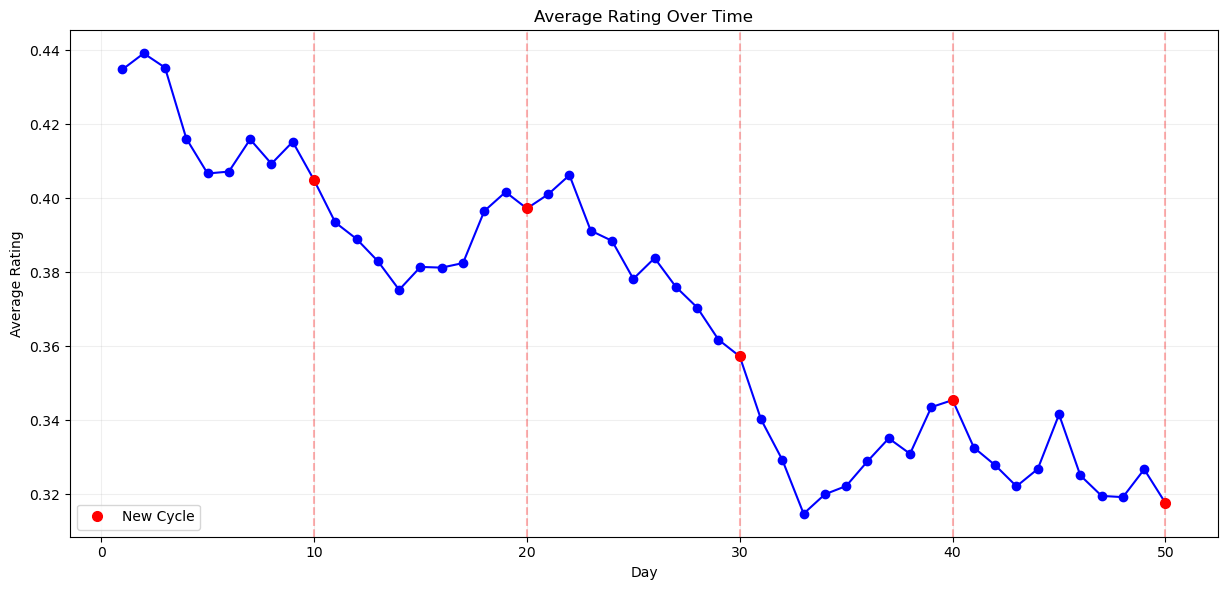

In [9]:
# Plot the simulation history
plt.figure(figsize=(24, 6), tight_layout=True)

# Plot average ratings over time
plt.subplot(1, 2, 1)

# Plot main line
plt.plot(history_df['day'], history_df['avg_rating'], marker='o', color='blue')

# Add markers for every 10th day in a different color
cycle_days = history_df[history_df['day'] % 10 == 0]
plt.plot(cycle_days['day'], cycle_days['avg_rating'], 'ro', markersize=7, label='New Cycle')

# Add vertical lines for cycle boundaries
for day in cycle_days['day']:
    plt.axvline(x=day, color='red', linestyle='--', alpha=0.3)

plt.title('Average Rating Over Time')
plt.xlabel('Day')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.2)
plt.legend()

>Under equal weights, the graph typically shows a gradual decrease in average ratings over time. This pattern reflects the playlist's intentional balance between user satisfaction and exploration, prioritizing the discovery of new artists, genres, and songs. The periodic dips at cycle boundaries (red markers) indicate when fresh content is introduced, usually causing lowering ratings but allowing user preferences to explore and potentially adapt.

### Robustness & Sensitivity Analysis


Starting Robustness & Sensitivity Analysis...

Varying w1...
Creating Song Selection Model...
Adding artist mapping constraints (this may take a while)...
All constraints added, ready to optimize
Optimizing the model...
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7485 rows, 1372995 columns and 57076 nonzeros
Model fingerprint: 0xe4d3d0e0
Variable types: 0 continuous, 1372995 integer (1372995 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+02]
Found heuristic solution: objective 12112.457229
Presolve removed 1 rows and 1345465 columns
Presolve time: 0.06s
Presolved: 7484 rows, 27530 columns, 57007 nonzeros
Found heuristic solution: objective 12112.115229
Variable types: 0 continuous, 27530 integer (27530 bin

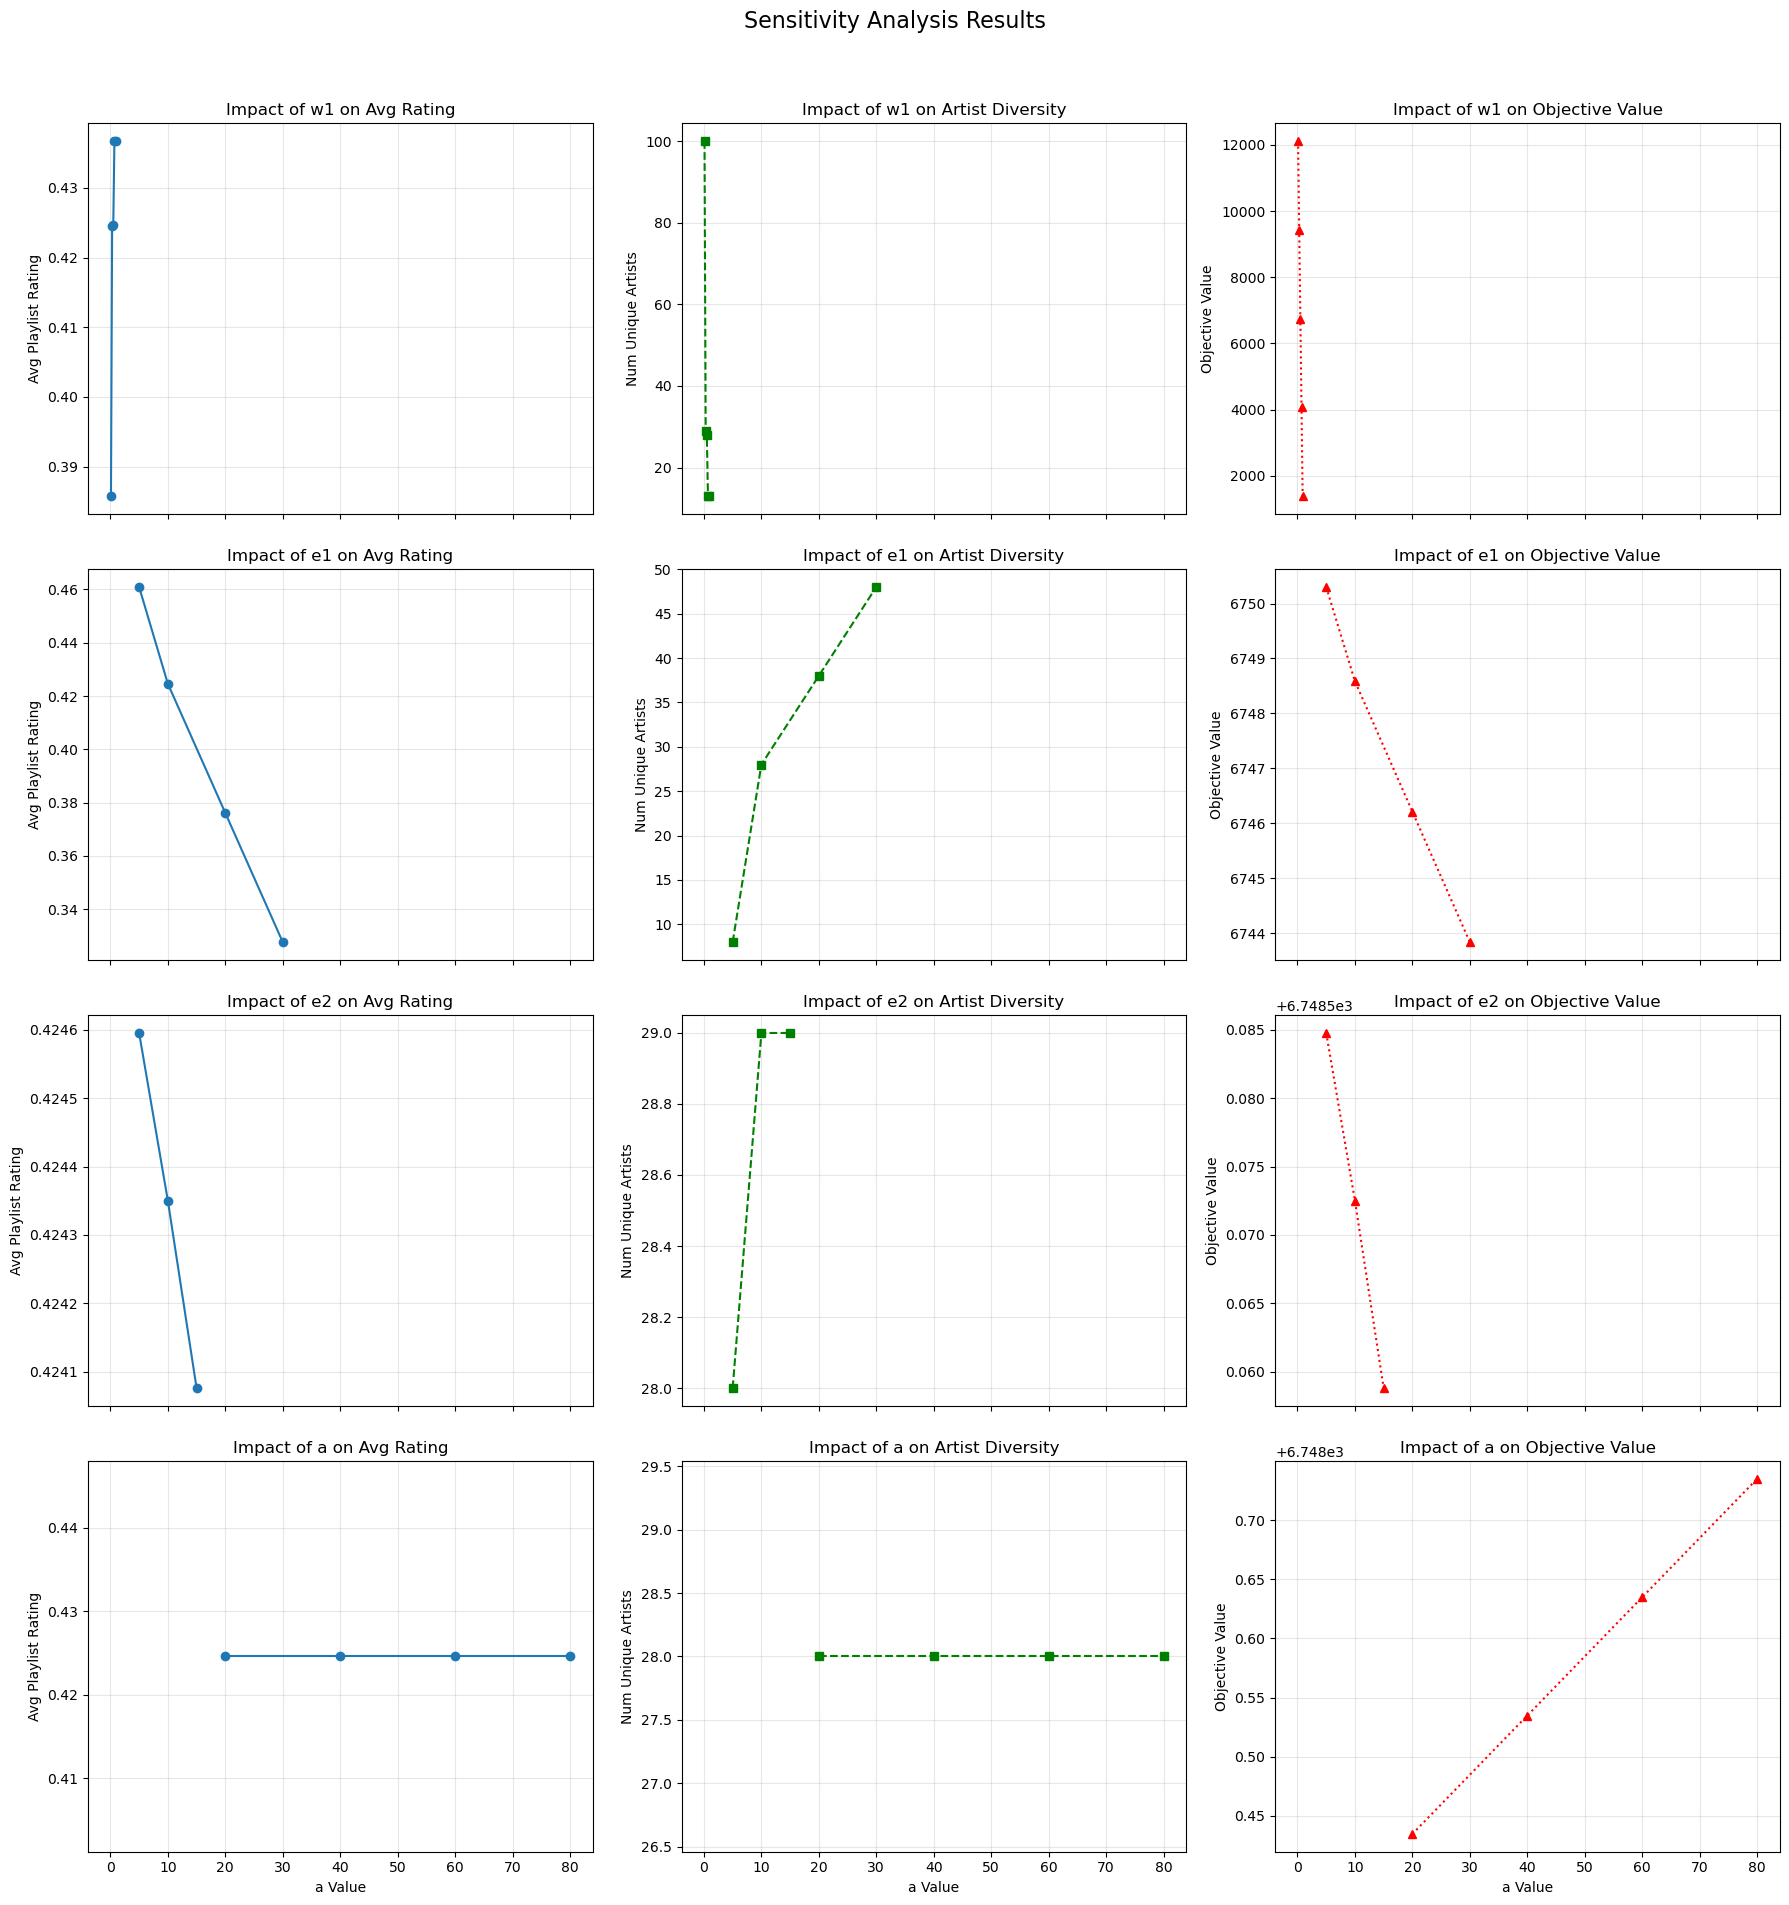


Sensitivity Analysis Results Summary:
   param  value  avg_rating  num_artists       obj_val
0     w1    0.1    0.385782          100  12113.771818
1     w1    0.3    0.424454           29   9431.037624
2     w1    0.5    0.424595           28   6748.584770
3     w1    0.7    0.436694           13   4066.936557
4     w1    0.9    0.436694           13   1384.758430
5     e1    5.0    0.460907            8   6750.300345
6     e1   10.0    0.424595           28   6748.584770
7     e1   20.0    0.376136           38   6746.211781
8     e1   30.0    0.327659           48   6743.837948
9     e2    5.0    0.424595           28   6748.584770
10    e2   10.0    0.424350           29   6748.572506
11    e2   15.0    0.424076           29   6748.558800
12     a   20.0    0.424595           28   6748.434770
13     a   40.0    0.424595           28   6748.534770
14     a   60.0    0.424595           28   6748.634770
15     a   80.0    0.424595           28   6748.734770


In [10]:
# --- Robustness & Sensitivity Analysis ---
import time
param_ranges = {
    'w1': [0.1, 0.3, 0.5, 0.7, 0.9], # Weight for ratings (w2 = 1 - w1)
    'e1': [5, 10, 20, 30],          # Min exploratory songs
    'e2': [5, 10, 15],             # Min next-genre songs
    'a': [20, 40, 60, 80]          # Max popular artists
}

# Store results
results = []

print("Starting Robustness & Sensitivity Analysis...")
start_time = time.time()

# Iterate through one parameter at a time, keeping others at default/mid values
# Default values (can adjust these)
default_w1 = 0.5
default_e1 = 10
default_e2 = 5
default_a = 50

# Vary w1
print("\nVarying w1...")
for w1_val in param_ranges['w1']:
    w2_val = 1.0 - w1_val
    selected_df, obj_val = select_songs(user, w1_val, w2_val, default_e1, default_e2, default_a,
                                      songs_data, all_songs, all_artists, exploratory_songs_indices,
                                      popular_artists_list, next_best_genre)
    if selected_df is not None:
        avg_rating = selected_df[user].mean()
        num_artists = selected_df['artist_name'].nunique()
        results.append({'param': 'w1', 'value': w1_val, 'avg_rating': avg_rating, 'num_artists': num_artists, 'obj_val': obj_val})

# Vary e1
print("\nVarying e1...")
for e1_val in param_ranges['e1']:
     # Ensure e1 + e2 <= 100
     if e1_val + default_e2 <= 100:
         selected_df, obj_val = select_songs(user, default_w1, 1-default_w1, e1_val, default_e2, default_a,
                                           songs_data, all_songs, all_artists, exploratory_songs_indices,
                                           popular_artists_list, next_best_genre)
         if selected_df is not None:
             avg_rating = selected_df[user].mean()
             num_artists = selected_df['artist_name'].nunique()
             results.append({'param': 'e1', 'value': e1_val, 'avg_rating': avg_rating, 'num_artists': num_artists, 'obj_val': obj_val})
     else:
          print(f"Skipping e1={e1_val} as e1+e2 > 100")


# Vary e2
print("\nVarying e2...")
for e2_val in param_ranges['e2']:
     # Ensure e1 + e2 <= 100
     if default_e1 + e2_val <= 100:
         # Code to suppress the output of the select_songs function
        import sys
        old_stdout = sys.stdout  
        sys.stdout = open('/dev/null', 'w')
        #####

        selected_df, obj_val = select_songs(user, default_w1, 1-default_w1, default_e1, e2_val, default_a,
                                           songs_data, all_songs, all_artists, exploratory_songs_indices,
                                           popular_artists_list, next_best_genre)
        #####
        # Restore output
        sys.stdout = old_stdout
        #####
         
        if selected_df is not None:
             avg_rating = selected_df[user].mean()
             num_artists = selected_df['artist_name'].nunique()
             results.append({'param': 'e2', 'value': e2_val, 'avg_rating': avg_rating, 'num_artists': num_artists, 'obj_val': obj_val})
     else:
          print(f"Skipping e2={e2_val} as e1+e2 > 100")

# Vary a
print("\nVarying a...")
for a_val in param_ranges['a']:
    selected_df, obj_val = select_songs(user, default_w1, 1-default_w1, default_e1, default_e2, a_val,
                                      songs_data, all_songs, all_artists, exploratory_songs_indices,
                                      popular_artists_list, next_best_genre)
    if selected_df is not None:
        avg_rating = selected_df[user].mean()
        num_artists = selected_df['artist_name'].nunique()
        results.append({'param': 'a', 'value': a_val, 'avg_rating': avg_rating, 'num_artists': num_artists, 'obj_val': obj_val})


end_time = time.time()
print(f"\nSensitivity Analysis Complete. Time taken: {end_time - start_time:.2f} seconds.")

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results)

# --- Plotting Results ---
if not results_df.empty:
    fig, axes = plt.subplots(len(param_ranges), 3, figsize=(18, 5 * len(param_ranges)), sharex='col')
    fig.suptitle('Sensitivity Analysis Results', fontsize=16)

    plot_idx = 0
    for param_name, values in param_ranges.items():
        param_data = results_df[results_df['param'] == param_name].sort_values('value')

        if not param_data.empty:
            # Plot Average Rating
            ax = axes[plot_idx, 0]
            ax.plot(param_data['value'], param_data['avg_rating'], marker='o', linestyle='-')
            ax.set_ylabel('Avg Playlist Rating')
            ax.set_title(f'Impact of {param_name} on Avg Rating')
            ax.grid(True, alpha=0.3)

            # Plot Number of Unique Artists
            ax = axes[plot_idx, 1]
            ax.plot(param_data['value'], param_data['num_artists'], marker='s', linestyle='--', color='green')
            ax.set_ylabel('Num Unique Artists')
            ax.set_title(f'Impact of {param_name} on Artist Diversity')
            ax.grid(True, alpha=0.3)

            # Plot Objective Value
            ax = axes[plot_idx, 2]
            ax.plot(param_data['value'], param_data['obj_val'], marker='^', linestyle=':', color='red')
            ax.set_ylabel('Objective Value')
            ax.set_title(f'Impact of {param_name} on Objective Value')
            ax.grid(True, alpha=0.3)

            # Set x-label only for the bottom row
            if plot_idx == len(param_ranges) - 1:
                 axes[plot_idx, 0].set_xlabel(f'{param_name} Value')
                 axes[plot_idx, 1].set_xlabel(f'{param_name} Value')
                 axes[plot_idx, 2].set_xlabel(f'{param_name} Value')


        plot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()

    # Display results table
    print("\nSensitivity Analysis Results Summary:")
    print(results_df)
else:
    print("\nNo results generated from sensitivity analysis. Check for errors during optimization.")
